# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [1]:
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance
import cv2
from typing import List, Tuple
import copy

import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.5.1+cu118
11.8
True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split # used for splitting the dataset in train and test
        self.paths, self.labels = self.read_file() #reading the labels and images

        self.transform = transform 

    def __len__(self) -> int: #get the number of elements in the dataset
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]: 
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    # legge un file di testo che contiene i percorsi delle immagini e le etichette associate
    # restituisce due liste: una con percorsi delle immagini e una con le etichette
    def read_file(self) -> Tuple[List[str], List[int]]: #outputs a tuple
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ") #rimuove il carattere di nuova linea, e poi divide in 3 parti con virgola come separatore 
                paths.append(path), labels.append(int(label)) #salva solo percorsi ed etichette

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [14]:
def calculate_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(train_loader)

print(f"Mean: {mean}") 
print(f"Std: {std}")

Mean: tensor([0.5306, 0.3964, 0.2564])
Std: tensor([0.2293, 0.2060, 0.1746])


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [16]:
train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

In [17]:
train_elements = len(train_dataset)
print(f"Number of elements in the train dataset: {train_elements}")

test_elements = len(test_dataset)
print(f"Number of elements in the test dataset: {test_elements}")

val_elements = len(val_dataset)
print(f"Number of elements in the val dataset: {val_elements}")

Number of elements in the train dataset: 2640
Number of elements in the test dataset: 2485
Number of elements in the val dataset: 296


In [18]:
img, label = train_dataset[2040]
print(f"Label: {label}")
#img.show()  # Mostra l'immagine

Label: 29


In [19]:
#transform = transforms.ToTensor()
#img_tensor = transform(img)
print(f"Images shape: ", img.shape)

Images shape:  torch.Size([3, 224, 224])


Initial images shape:  torch.Size([3, 348, 348])
- 3 canali = immagine a colori (rgb)
- 348 pixel di altezza
- 348 pixel di larghezza

è un'immagine rgb quadrata con risolutione 348x348 pixel

Trasformata in torch.Size([3, 224, 224]) - necessario che rimanga così perchè le resnet richiedono questa size

In [20]:
train_num_classes = train_dataset.get_num_classes()
print(f"Num classes in train dataset: ", train_num_classes) #43 perchè la prima ha index 0

test_num_classes = test_dataset.get_num_classes()
print(f"Num classes in test dataset: ", test_num_classes)

val_num_classes = val_dataset.get_num_classes()
print(f"Num classes in val dataset: ", val_num_classes)

#ogni dataset ha lo stesso numero di classi, lo split è stato fatto corettamente 

Num classes in train dataset:  43
Num classes in test dataset:  43
Num classes in val dataset:  43


In [22]:
paths, labels = train_dataset.read_file()

# Stampare i primi 5 percorsi e le etichette corrispondenti
print("First 5 paths:", paths[:5])
print("First 5 labels:", labels[:5])

First 5 paths: ['train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg', 'train/Fruit/Apple/Golden-Delicious/Golden-Delicious_002.jpg', 'train/Fruit/Apple/Golden-Delicious/Golden-Delicious_003.jpg', 'train/Fruit/Apple/Golden-Delicious/Golden-Delicious_004.jpg', 'train/Fruit/Apple/Golden-Delicious/Golden-Delicious_005.jpg']
First 5 labels: [0, 0, 0, 0, 0]


# Simple CNN 

https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch


 The first layer of a CNN is always a convolutional layer. A convolutional layer applies a filter (or kernel) to the input, and passes the result to the next layer. The filter is usually smaller that the image (most often, we can find 3x3 or 5x5 filters), and it moves across the image from top left to bottom right, detecting different features and simplifying the image before passing it onto the next layer. With each convolutional layer, we have to use an activation function. ReLU is a linear function that became the default activation function for many types of neural networks, because it makes the model easy to train, doesn‘t get the vanishing gradient problem compared to Sigmoid and TanH, and often achieves better results.

Conv2D

There are many different types of convolutional layers, but 2D Convolution Layer (Conv2D) is the most common one. The filter "slides" over the 2D input data and multiplies each pixel. As a result, it sums up everything to a single output pixel.

Input shape

As input, CNN takes tensors of shape (image_height, image_width, color_channels). For color images, color channels are RGB (red, green, blue). The format of CIFAR images is (32, 32, 3), so that‘s what we will pass to the CNN.

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 53 * 53, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

s_cnn = SimpleCNN()
s_cnn.to(device)
summary(s_cnn, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 43]           3,655
Total params: 5,410,091
Trainable params: 5,410,091
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 20.64
Estimated Total Size (MB): 25.70
----------------------------------------------------------------



**kernel_size**

- specifica la dimensione della finestra del filtro che viene applicata all'immagine durante l'operazione di convoluzione
- se kernel_size=3 allora il filtro sarà una matrice 3x3
- un kernel grande cattura più contesto dell'immaigne ma aumenta anche il numero di parametri e il costo computazionale 

**stride**
- specifica di quanti pixel il filtro si sposta o striscia (?) sull'immagine durante l'operazione di convoluzione
- se stride=1 si sposta di un pixel alla volta, se stride=2 di due pixel alla volta e così via 
- un stride maggiore riduce la dimensione spaziale dell'output poichè il filtro copre meno posizioni sull'immagine

**padding**
- aggiunge pixel extra (tipicamente con valore zero) attorno ai bordi dell'immagine prima di applicare la convoluzione
- se padding=1 viene aggiunto un bordo di un pixel attorno all'immagine
- aiuta a preservare la dimensione spaziale dell'immagine dopo la convoluzione, senza la dimensione dell'immagine si riduce ad ogni convoluzione

**MaxPooling (MaxPool2d)**

Il layer di Max Pooling (MaxPool2d in PyTorch) è utilizzato nelle reti neurali convoluzionali (CNN) per ridurre la dimensione spaziale (altezza e larghezza) dell'input (che porta a una riduzione del numero di parametri e del costo computazionale nei layer successivi), mantenendo le caratteristiche più importanti (seleziona il valore massimo in ogni finestra del kernel). Questo processo è noto come "downsampling". Utile anche per la riduzione di overfitting. 
Gli strati di maxpooling tipicamente vengono aggiunti dopo ogni convolutional layer insieme a un layer relu

In [22]:
class CNN_2(nn.Module):
    def __init__(self, num_classes=43):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(64*56*56, 128)
        self.relu1 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.dropout1(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu1(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu1(out)
        out = self.pool2(out)
        out = self.dropout2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        return out

In [23]:
cnn_2 = CNN_2()
cnn_2.to(device)
summary(cnn_2, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
           Dropout-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]          18,496
      BatchNorm2d-10         [-1, 64, 112, 112]             128
             ReLU-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,928
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

In [24]:
class MidCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(MidCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224))
        
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def convs(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        if self._to_linear is None:
            self._to_linear = x.view(-1).shape[0]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
mid_cnn= MidCNN()
mid_cnn.to(device)
summary(mid_cnn, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
         MaxPool2d-2         [-1, 16, 110, 110]               0
            Conv2d-3         [-1, 32, 106, 106]          12,832
         MaxPool2d-4           [-1, 32, 53, 53]               0
            Conv2d-5           [-1, 64, 53, 53]          18,496
         MaxPool2d-6           [-1, 64, 26, 26]               0
            Linear-7                  [-1, 128]       5,537,920
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 84]          10,836
           Linear-10                   [-1, 43]           3,655
Total params: 5,584,955
Trainable params: 5,584,955
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 12.52
Params size (MB): 21.30
Estim

#### hyperparameters

In [26]:
#loss function
loss_fn = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.AdamW(mid_cnn.parameters(), lr=0.0001, weight_decay=0.0001)

scheduler = StepLR(optimizer, step_size=7, gamma=0.1) #Il StepLR scheduler riduce il tasso di apprendimento di un fattore specificato (gamma) ogni determinato numero di epoche (step_size). Questo può aiutare il modello a convergere in modo più stabile e a evitare di oscillare o di rimanere bloccato in minimi locali.

batch_size = 32
num_epochs =30
patience = 7

### DataLoader

In [27]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [28]:
def train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):

        # Initialize metrics for this epoch
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Save losses and accuracies
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        # Deep copy the model if validation accuracy improves
        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        # Step the scheduler
        scheduler.step()

    print(f'Minimun val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [29]:
cnn_model, train_losses, train_accuracies, val_losses, val_accuracies, = train_model(mid_cnn, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 3.5010 Acc: 0.1129 | Val Loss: 3.3110 Acc: 0.1486
Epoch [2/30], Train Loss: 3.0904 Acc: 0.1833 | Val Loss: 3.0979 Acc: 0.2297
Epoch [3/30], Train Loss: 2.8397 Acc: 0.2364 | Val Loss: 2.9557 Acc: 0.2331
Epoch [4/30], Train Loss: 2.6477 Acc: 0.2708 | Val Loss: 2.8965 Acc: 0.2297
Epoch [5/30], Train Loss: 2.4958 Acc: 0.3045 | Val Loss: 2.8308 Acc: 0.2196
Epoch [6/30], Train Loss: 2.3470 Acc: 0.3250 | Val Loss: 2.7952 Acc: 0.2162
Epoch [7/30], Train Loss: 2.2367 Acc: 0.3583 | Val Loss: 2.6674 Acc: 0.2466
Epoch [8/30], Train Loss: 2.1003 Acc: 0.3920 | Val Loss: 2.6693 Acc: 0.2297
Epoch [9/30], Train Loss: 2.0672 Acc: 0.3947 | Val Loss: 2.6506 Acc: 0.2331
Epoch [10/30], Train Loss: 2.0416 Acc: 0.3981 | Val Loss: 2.6649 Acc: 0.2365
Epoch [11/30], Train Loss: 2.0238 Acc: 0.3894 | Val Loss: 2.6481 Acc: 0.2399
Epoch [12/30], Train Loss: 2.0157 Acc: 0.3996 | Val Loss: 2.6402 Acc: 0.2399
Epoch [13/30], Train Loss: 1.9779 Acc: 0.4068 | Val Loss: 2.6298 Acc: 0.2432
Epoch [1

C:\Users\alessia\AppData\Local\Temp\2\ipykernel_6212\2917145924.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, train_losses, 'bo-', label='Train Loss', color='blue', marker='o')
C:\Users\alessia\AppData\Local\Temp\2\ipykernel_6212\2917145924.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, train_losses, 'bo-', label='Train Loss', color='blue', marker='o')
C:\Users\alessia\AppData\Local\Temp\2\ipykernel_6212\2917145924.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, val_losses, 'go-', label='Val Loss', color='green', marker='o')
C:\Users\alessia\AppData\Local\Temp\2\ipykernel_6212

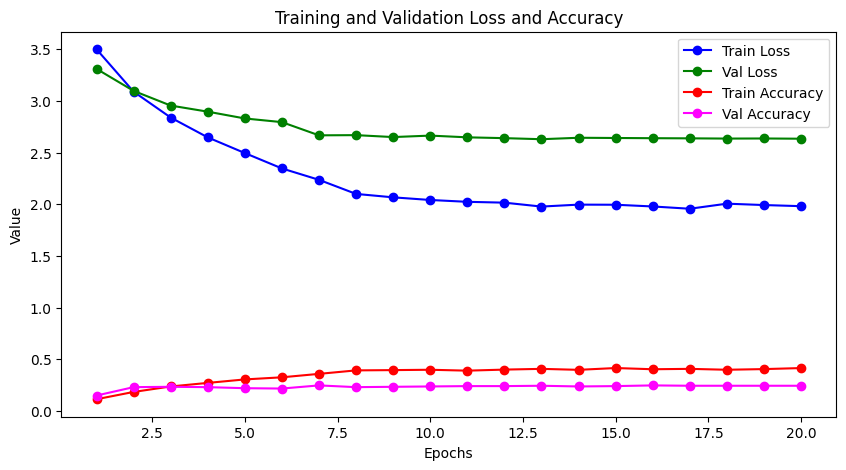

In [30]:
import matplotlib.pyplot as plt
from typing import List

def plot_training_history(train_losses: List[float], val_losses: List[float], train_accuracies: List[float], val_accuracies: List[float]):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # Plot loss
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, 'go-', label='Val Loss', color='green', marker='o')
    
    # Plot accuracy
    plt.plot(epochs, train_accuracies, 'ro-', label='Train Accuracy', color='red', marker='o')
    plt.plot(epochs, val_accuracies, 'mo-', label='Val Accuracy', color='magenta', marker='o')
    
    plt.title('Training and Validation Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.